In [289]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge

In [290]:
hhpub_file_path = 'C:/AdvayRepos/personal_projects/gm_proj/data/hhpub.csv'
vehpub_file_path = 'C:/AdvayRepos/personal_projects/gm_proj/data/vehpub.csv'
perpub_file_path = 'C:/AdvayRepos/personal_projects/gm_proj/data/perpub.csv'

household_data = pd.read_csv(hhpub_file_path)
vehicle_data = pd.read_csv(vehpub_file_path)
personal_data = pd.read_csv(perpub_file_path)

In [291]:
household_data.describe()
#7893 counts


,HOUSEID,WTHHFIN,WTHHFIN5D,WTHHFIN2D,NUMADLT,HOMEOWN,HOMETYPE,RAIL,CENSUS_D,CENSUS_R,...,URBAN,URBANSIZE,URBRUR,PPT517,YOUNGCHILD,RESP_CNT,URBRUR_2010,TDAYDATE,WRKCOUNT,STRATUMID
count,7.893000e+03,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,...,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000
mean,9.000114e+09,16159.217915,16159.217915,16159.217915,1.839351,1.810338,1.566451,1.770936,5.118079,2.641074,...,1.688458,4.181680,1.201064,0.328012,0.104523,2.153427,1.202078,202211.579881,0.996579,1029.458761
std,5.942851e+04,17180.725602,22608.285125,41523.170801,0.753459,0.856616,0.912436,0.420257,2.483650,1.009971,...,1.191865,1.658407,0.400821,0.780185,0.390389,1.132906,0.401575,20.202111,0.902558,4.987184
min,9.000013e+09,103.586134,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,202201.000000,0.000000,1021.000000
25%,9.000057e+09,6384.534030,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,3.000000,2.000000,...,1.000000,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000,202204.000000,0.000000,1025.000000
50%,9.000107e+09,11052.323538,10178.336240,0.000000,2.000000,2.000000,1.000000,2.000000,5.000000,3.000000,...,1.000000,5.000000,1.000000,0.000000,0.000000,2.000000,1.000000,202208.000000,1.000000,1029.000000
75%,9.000166e+09,19498.165382,21556.477769,14757.858351,2.000000,3.000000,2.000000,2.000000,7.000000,3.000000,...,2.000000,6.000000,1.000000,0.000000,0.000000,3.000000,1.000000,202211.000000,2.000000,1033.000000
max,9.000218e+09,308074.698840,468464.128880,746881.674760,8.000000,4.000000,5.000000,2.000000,9.000000,4.000000,...,4.000000,6.000000,2.000000,6.000000,4.000000,10.000000,2.000000,202301.000000,6.000000,1040.000000


In [292]:
df = pd.merge(vehicle_data, household_data, on='HOUSEID', how='inner')

# Identify duplicate columns
duplicates = [col for col in df.columns if col.endswith(('_x'))]

# Drop the duplicate columns
df = df.drop(columns=duplicates)

# Rename columns with '_y' suffix by removing the suffix
df = df.rename(columns={col: col.replace('_y', '') for col in df.columns})


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14684 entries, 0 to 14683
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HOUSEID           14684 non-null  int64  
 1   VEHID             14684 non-null  int64  
 2   VEHYEAR           14684 non-null  int64  
 3   MAKE              14684 non-null  int64  
 4   VEHTYPE           14684 non-null  int64  
 5   VEHFUEL           14684 non-null  int64  
 6   VEHCOMMERCIAL     14684 non-null  int64  
 7   VEHCOM_RS         14684 non-null  int64  
 8   VEHCOM_DEL        14684 non-null  int64  
 9   VEHCOM_OTH        14684 non-null  int64  
 10  COMMERCIALFREQ    14684 non-null  int64  
 11  HHVEHUSETIME_RS   14684 non-null  int64  
 12  HHVEHUSETIME_DEL  14684 non-null  int64  
 13  HHVEHUSETIME_OTH  14684 non-null  int64  
 14  VEHOWNED          14684 non-null  int64  
 15  WHOMAIN           14684 non-null  int64  
 16  VEHCASEID         14684 non-null  int64 

In [293]:
df.dtypes

HOUSEID               int64
VEHID                 int64
VEHYEAR               int64
MAKE                  int64
VEHTYPE               int64
VEHFUEL               int64
VEHCOMMERCIAL         int64
VEHCOM_RS             int64
VEHCOM_DEL            int64
VEHCOM_OTH            int64
COMMERCIALFREQ        int64
HHVEHUSETIME_RS       int64
HHVEHUSETIME_DEL      int64
HHVEHUSETIME_OTH      int64
VEHOWNED              int64
WHOMAIN               int64
VEHCASEID             int64
ANNMILES              int64
HYBRID                int64
VEHAGE                int64
VEHOWNMO              int64
WTHHFIN             float64
WTHHFIN5D           float64
WTHHFIN2D           float64
NUMADLT               int64
HOMEOWN               int64
HOMETYPE              int64
RAIL                  int64
CENSUS_D              int64
CENSUS_R              int64
HH_HISP               int64
DRVRCNT               int64
CNTTDHH               int64
CDIVMSAR              int64
FLAG100               int64
HHFAMINC            

In [294]:
df.isna().sum()
#no null values

HOUSEID             0
VEHID               0
VEHYEAR             0
MAKE                0
VEHTYPE             0
VEHFUEL             0
VEHCOMMERCIAL       0
VEHCOM_RS           0
VEHCOM_DEL          0
VEHCOM_OTH          0
COMMERCIALFREQ      0
HHVEHUSETIME_RS     0
HHVEHUSETIME_DEL    0
HHVEHUSETIME_OTH    0
VEHOWNED            0
WHOMAIN             0
VEHCASEID           0
ANNMILES            0
HYBRID              0
VEHAGE              0
VEHOWNMO            0
WTHHFIN             0
WTHHFIN5D           0
WTHHFIN2D           0
NUMADLT             0
HOMEOWN             0
HOMETYPE            0
RAIL                0
CENSUS_D            0
CENSUS_R            0
HH_HISP             0
DRVRCNT             0
CNTTDHH             0
CDIVMSAR            0
FLAG100             0
HHFAMINC            0
HHFAMINC_IMP        0
HH_RACE             0
HHSIZE              0
HHVEHCNT            0
HHRELATD            0
LIF_CYC             0
MSACAT              0
MSASIZE             0
TRAVDAY             0
URBAN     

In [295]:
df.describe()

,HOUSEID,VEHID,VEHYEAR,MAKE,VEHTYPE,VEHFUEL,VEHCOMMERCIAL,VEHCOM_RS,VEHCOM_DEL,VEHCOM_OTH,...,URBAN,URBANSIZE,URBRUR,PPT517,YOUNGCHILD,RESP_CNT,URBRUR_2010,TDAYDATE,WRKCOUNT,STRATUMID
count,1.468400e+04,14684.000000,14684.000000,14684.000000,14684.000000,14684.000000,14684.000000,14684.000000,14684.000000,14684.000000,...,14684.000000,14684.000000,14684.000000,14684.000000,14684.000000,14684.000000,14684.000000,14684.000000,14684.000000,14684.000000
mean,9.000113e+09,1.767162,2011.866658,33.115432,2.738355,1.456892,1.875306,-0.872991,-0.883683,-0.867952,...,1.821779,4.269205,1.245165,0.387837,0.109030,2.428153,1.244620,202211.722623,1.179447,1029.614751
std,5.936829e+04,1.067399,8.009252,21.638290,5.859410,4.737240,0.633504,1.257711,1.249377,0.925508,...,1.271618,1.691505,0.430200,0.839105,0.395132,1.195271,0.429876,20.578951,0.984043,4.947836
min,9.000013e+09,1.000000,1982.000000,0.000000,1.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,202201.000000,0.000000,1021.000000
25%,9.000057e+09,1.000000,2007.000000,12.000000,1.000000,1.000000,2.000000,-1.000000,-1.000000,-1.000000,...,1.000000,3.000000,1.000000,0.000000,0.000000,2.000000,1.000000,202204.000000,0.000000,1025.000000
50%,9.000107e+09,1.000000,2014.000000,35.000000,3.000000,1.000000,2.000000,-1.000000,-1.000000,-1.000000,...,1.000000,5.000000,1.000000,0.000000,0.000000,2.000000,1.000000,202208.000000,1.000000,1029.000000
75%,9.000166e+09,2.000000,2018.000000,49.000000,3.000000,1.000000,2.000000,-1.000000,-1.000000,-1.000000,...,2.000000,6.000000,1.000000,0.000000,0.000000,3.000000,1.000000,202211.000000,2.000000,1034.000000
max,9.000218e+09,17.000000,2023.000000,98.000000,97.000000,97.000000,2.000000,2.000000,2.000000,2.000000,...,4.000000,6.000000,2.000000,6.000000,4.000000,10.000000,2.000000,202301.000000,6.000000,1040.000000


In [296]:
df.columns

Index(['HOUSEID', 'VEHID', 'VEHYEAR', 'MAKE', 'VEHTYPE', 'VEHFUEL',
       'VEHCOMMERCIAL', 'VEHCOM_RS', 'VEHCOM_DEL', 'VEHCOM_OTH',
       'COMMERCIALFREQ', 'HHVEHUSETIME_RS', 'HHVEHUSETIME_DEL',
       'HHVEHUSETIME_OTH', 'VEHOWNED', 'WHOMAIN', 'VEHCASEID', 'ANNMILES',
       'HYBRID', 'VEHAGE', 'VEHOWNMO', 'WTHHFIN', 'WTHHFIN5D', 'WTHHFIN2D',
       'NUMADLT', 'HOMEOWN', 'HOMETYPE', 'RAIL', 'CENSUS_D', 'CENSUS_R',
       'HH_HISP', 'DRVRCNT', 'CNTTDHH', 'CDIVMSAR', 'FLAG100', 'HHFAMINC',
       'HHFAMINC_IMP', 'HH_RACE', 'HHSIZE', 'HHVEHCNT', 'HHRELATD', 'LIF_CYC',
       'MSACAT', 'MSASIZE', 'TRAVDAY', 'URBAN', 'URBANSIZE', 'URBRUR',
       'PPT517', 'YOUNGCHILD', 'RESP_CNT', 'URBRUR_2010', 'TDAYDATE',
       'WRKCOUNT', 'STRATUMID'],
      dtype='object')

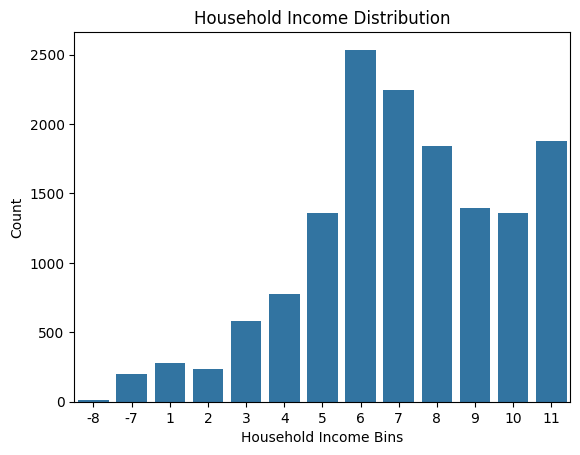

In [297]:
sns.countplot(x='HHFAMINC', data=df)
plt.title('Household Income Distribution')
plt.xlabel('Household Income Bins')
plt.ylabel('Count')
plt.show()
#6 is $50,000 to $74,999
#11 is $200k or more
#left skew slight may want normalization

Text(0, 0.5, 'Count')

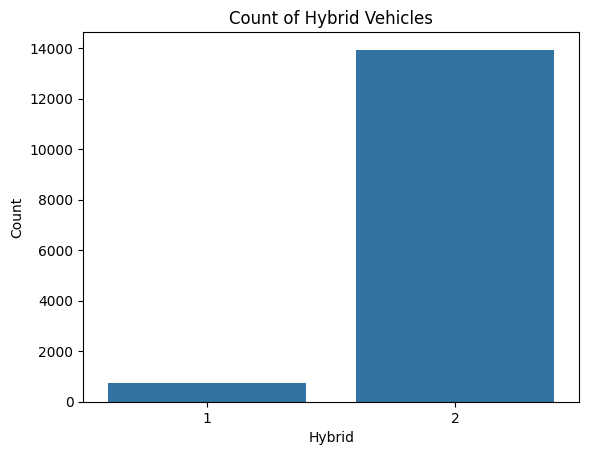

In [298]:
sns.countplot(x='HYBRID', data=df)
plt.title('Count of Hybrid Vehicles')
plt.xlabel('Hybrid')
plt.ylabel('Count')
#1 is yes so very very skewed

In [299]:
#let's see how many said yes
df['HYBRID'].value_counts()


HYBRID
2    13941
1      743
Name: count, dtype: int64

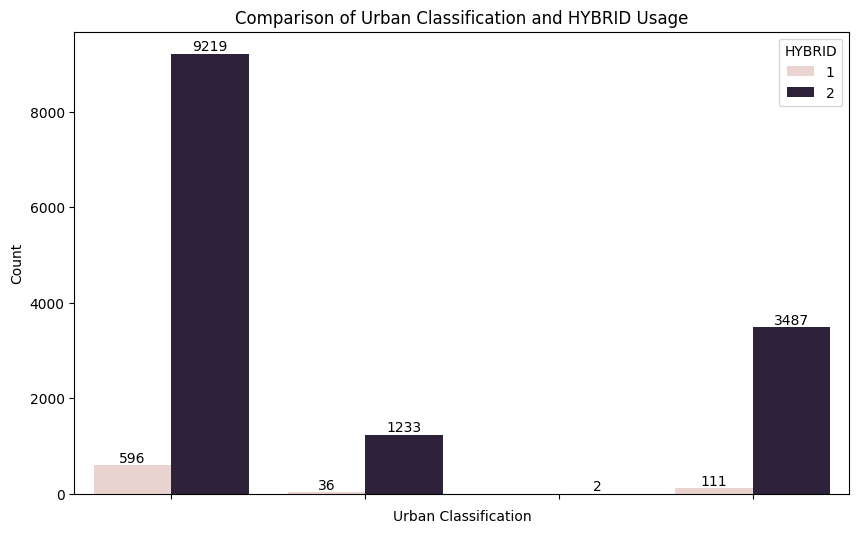

In [300]:



plt.figure(figsize=(10, 6))
ax = sns.countplot(x='URBAN', hue='HYBRID', data=df)
ax.set_title('Comparison of Urban Classification and HYBRID Usage')
ax.set_xlabel('Urban Classification')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(True), rotation=45)
for container in ax.containers:
    ax.bar_label(container)
plt.show()



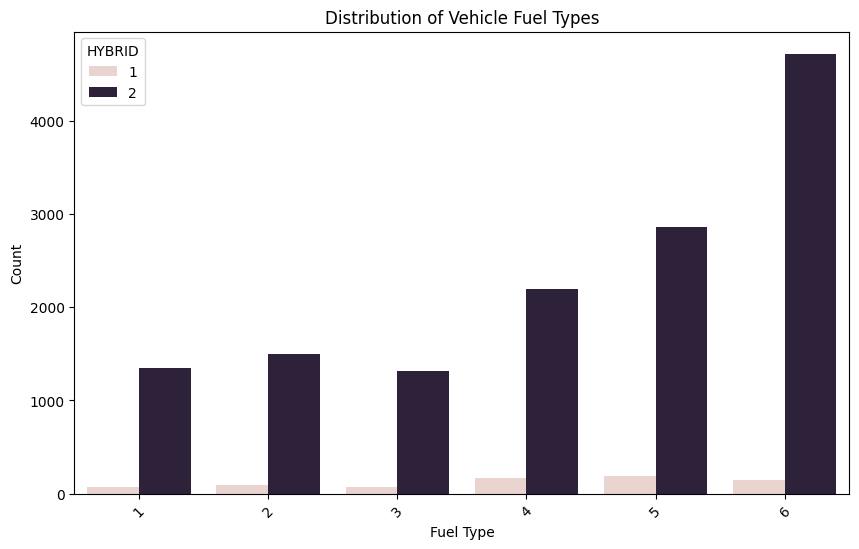

In [301]:


plt.figure(figsize=(10, 6))
sns.countplot(x='URBANSIZE', hue='HYBRID', data=df)
plt.title('Distribution of Vehicle Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


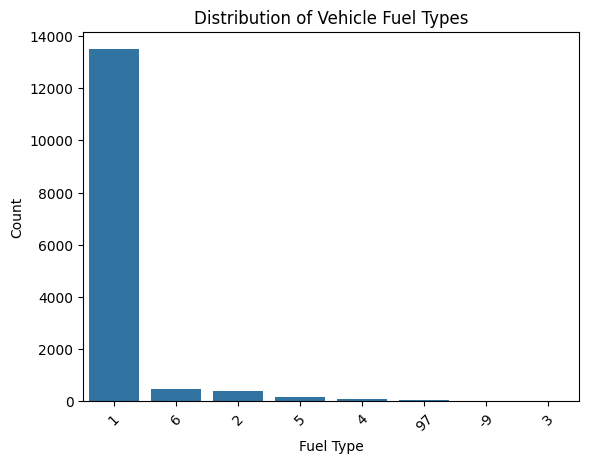

In [302]:


# Count plot for VEHFUEL variable
sns.countplot(x='VEHFUEL', data=df, order=df['VEHFUEL'].value_counts().index)
plt.title('Distribution of Vehicle Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [303]:
df.columns

Index(['HOUSEID', 'VEHID', 'VEHYEAR', 'MAKE', 'VEHTYPE', 'VEHFUEL',
       'VEHCOMMERCIAL', 'VEHCOM_RS', 'VEHCOM_DEL', 'VEHCOM_OTH',
       'COMMERCIALFREQ', 'HHVEHUSETIME_RS', 'HHVEHUSETIME_DEL',
       'HHVEHUSETIME_OTH', 'VEHOWNED', 'WHOMAIN', 'VEHCASEID', 'ANNMILES',
       'HYBRID', 'VEHAGE', 'VEHOWNMO', 'WTHHFIN', 'WTHHFIN5D', 'WTHHFIN2D',
       'NUMADLT', 'HOMEOWN', 'HOMETYPE', 'RAIL', 'CENSUS_D', 'CENSUS_R',
       'HH_HISP', 'DRVRCNT', 'CNTTDHH', 'CDIVMSAR', 'FLAG100', 'HHFAMINC',
       'HHFAMINC_IMP', 'HH_RACE', 'HHSIZE', 'HHVEHCNT', 'HHRELATD', 'LIF_CYC',
       'MSACAT', 'MSASIZE', 'TRAVDAY', 'URBAN', 'URBANSIZE', 'URBRUR',
       'PPT517', 'YOUNGCHILD', 'RESP_CNT', 'URBRUR_2010', 'TDAYDATE',
       'WRKCOUNT', 'STRATUMID'],
      dtype='object')

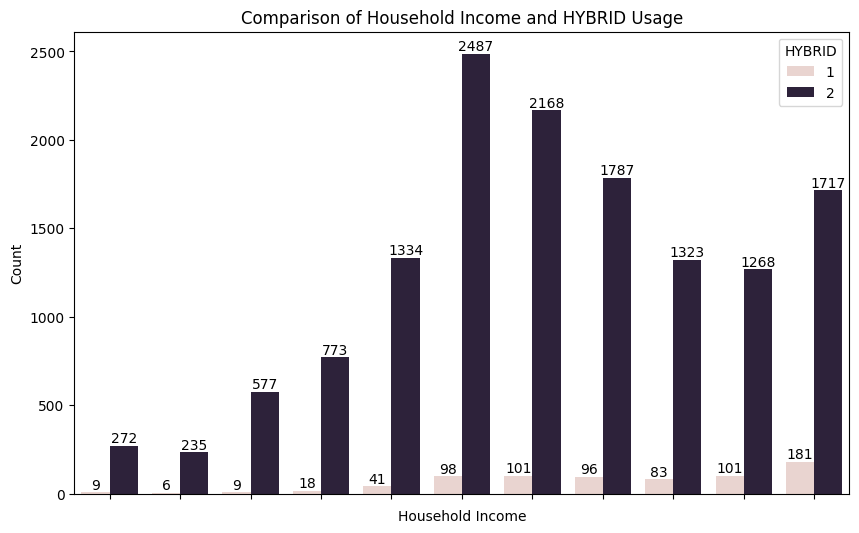

In [312]:


# Count plot for HYBRID by HHFAMINC_IMP
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='HHFAMINC_IMP', hue='HYBRID', data=df)
ax.set_title('Comparison of Household Income and HYBRID Usage')
ax.set_xlabel('Household Income')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(True), rotation=45)

# Add count above each bar using bar_label
for container in ax.containers:
    ax.bar_label(container)

plt.show()


In [314]:
# Filter the DataFrame for rows where HHFAMINC_IMP is 1 and HYBRID is 1
filtered_df = df[(df['HHFAMINC_IMP'] == 1) & (df['HYBRID'] == 1)]

# Count the number of rows in the filtered DataFrame
count_hybrid_and_hhfaminc = len(filtered_df)

# Total number of people with HHFAMINC_IMP = 1
total_hhfaminc_imp_1 = len(df[df['HHFAMINC_IMP'] == 1])

print(f"Number of people with HHFAMINC and HYBRID: {count_hybrid_and_hhfaminc}")
print(f"Total number of people with HHFAMINC_IMP: {total_hhfaminc_imp_1}")


Number of people with HHFAMINC and HYBRID: 9
Total number of people with HHFAMINC_IMP: 281


In [ ]:
df['HHFAMINC']

In [306]:
df.dtypes

HOUSEID               int64
VEHID                 int64
VEHYEAR               int64
MAKE                  int64
VEHTYPE               int64
VEHFUEL               int64
VEHCOMMERCIAL         int64
VEHCOM_RS             int64
VEHCOM_DEL            int64
VEHCOM_OTH            int64
COMMERCIALFREQ        int64
HHVEHUSETIME_RS       int64
HHVEHUSETIME_DEL      int64
HHVEHUSETIME_OTH      int64
VEHOWNED              int64
WHOMAIN               int64
VEHCASEID             int64
ANNMILES              int64
HYBRID                int64
VEHAGE                int64
VEHOWNMO              int64
WTHHFIN             float64
WTHHFIN5D           float64
WTHHFIN2D           float64
NUMADLT               int64
HOMEOWN               int64
HOMETYPE              int64
RAIL                  int64
CENSUS_D              int64
CENSUS_R              int64
HH_HISP               int64
DRVRCNT               int64
CNTTDHH               int64
CDIVMSAR              int64
FLAG100               int64
HHFAMINC            